# Covariance Matrix

_Alone, we can do so little; together, we can do so much_ - Helen Keller

The covariance matrix quantifies the relationships between asset returns, enabling investors to assess diversification benefits and manage portfolio risk. 
We begin by exploring risk budgeting, which breaks down a portfolio’s overall risk contribution by asset, and specifically risk parity portfolios, which aim to distribute risk evenly across assets. 
We then cover techniques for covariance matrix estimation, including principal component analysis (PCA), Exponentially Weighted Moving Average (EWMA), and shrinkage methods.


In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
from sklearn.decomposition import PCA
from pandas import DataFrame
import cvxpy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.covariance import LedoitWolf, OAS, EmpiricalCovariance
from sklearn import cluster
from finds.utils import ColorMap
from finds.readers import FFReader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# %matplotlib qt
VERBOSE = 0

## Portfolio risk

The covariance matrix is essential for portfolio risk analysis, helping investors evaluate diversification benefits and effectively manage overall risk. In this analysis, we use monthly returns from the 49 industry indexes compiled by Ken French.


In [2]:
# Retrieve industry returns from Ken French Data Library website
symbol = '49_Industry_Portfolios'
ff = FFReader(symbol)
keep = ff[0].index[(ff[0] > -99).all(axis=1)]
rets = (ff[0] / 100).reindex(keep)
caps = (ff[4] * ff[5] * 10e6).reindex(keep)   # number of firms x avg market cap
weights = caps.iloc[-1] / caps.iloc[-1].sum()

In [3]:
X = (rets - rets.mean(axis=0))    # demean by industry
sigma = 12 * X.T @ X / len(X)     # annualized covariance matrix
Y = caps.iloc[-1]\
        .rename('cap')\
        .to_frame()\
        .join(DataFrame({'vol': np.sqrt(np.diag(sigma))}, index=X.columns))\
        .sort_values('cap', ascending=False)

Text(0.5, 0, 'monthly returns (1969-07 to 2024-12)')

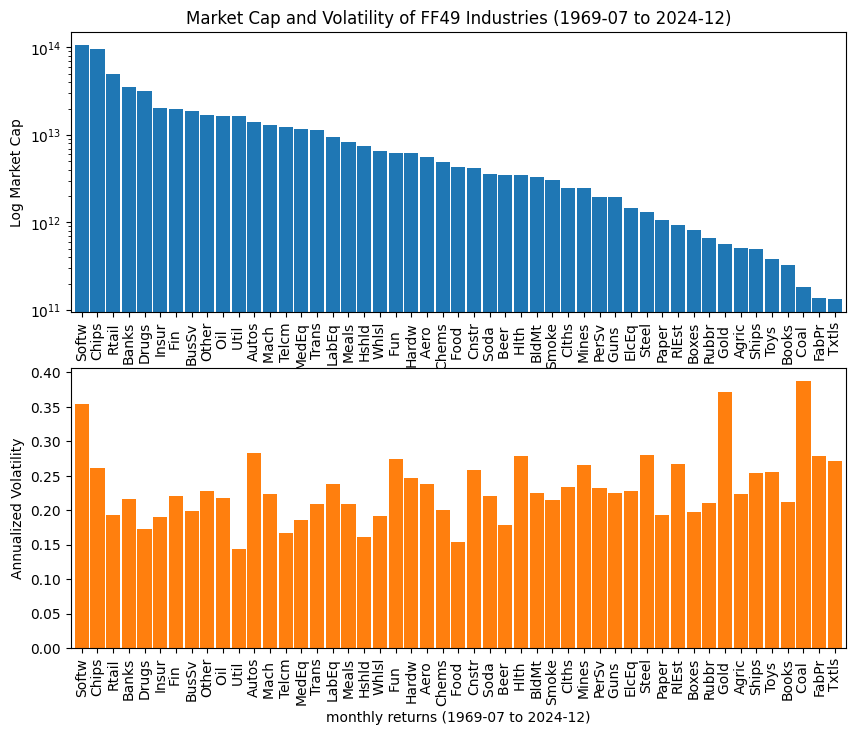

In [23]:
# Plot annualized volatility and market caps of industries
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
Y['cap'].plot.bar(ax=ax[0], color="C0", width=0.9)
ax[0].set_yscale('log')
ax[0].set_title(f"Market Cap and Volatility of FF49 Industries ({X.index[0]} to {X.index[-1]})")
ax[0].set_ylabel(f"Log Market Cap")
Y['vol'].plot.bar(ax=ax[1], color="C1", width=0.9)
ax[1].set_ylabel(f"Annualized Volatility")
ax[1].set_xlabel(f"monthly returns ({X.index[0]} to {X.index[-1]})")

### Risk budgetting

Risk budgeting breaks down a portfolio’s overall risk contribution by asset.

- **Portfolio Risk**: The volatility of a market portfolio is given by:  
  $$\sigma_P = W^T \Sigma W$$  
  where $ W $ represents the vector of asset weights in the portfolio, and $ \Sigma $ is the covariance matrix of asset returns.  

- **Covariance**: The covariance of an individual security $ i $ with the portfolio $ P $ is expressed as:  
  $$\sigma_{iP} = \rho_{iP} \cdot \sigma_i \cdot \sigma_P$$  
  where $ \rho_{iP} $ is the correlation between the security and the portfolio.  

- **Beta ($\beta$)**: The systematic risk of a security relative to the portfolio, defined as:  
  $$\beta_i = \dfrac{\sigma_{iP}}{\sigma_P^2}$$  
  This represents the regression slope of the security’s returns against the portfolio’s returns.  

- **Marginal Contribution to Risk (MCR)**: Measures the sensitivity of portfolio volatility to small changes in an asset’s weight:  
  $$\dfrac{\partial \sigma_P}{\partial w_i} = \dfrac{\sigma_{iP}}{\sigma_P}$$  

- **Percent Contribution to Risk (PCR)**: Indicates the fraction of total portfolio risk attributable to a security:  
  $$\beta_i \cdot w_i$$  
  The sum of all asset contributions equals 1.  

- **Contribution to Portfolio Risk**: The total portfolio risk can also be expressed as:  
  $$\beta_i \cdot w_i \cdot \sigma_P = w_i \cdot \sigma_i \cdot \rho_{iP}$$ 
  This highlights how an asset’s weight, volatility, and correlation with the portfolio drive its risk contribution.  



In [5]:
# Helper to compute portfolio risk budget
def risk_budget(w, sigma, labels):
    """Compute portfolio risk analytics"""
    sigma_ = np.array(sigma) * 100 * 100   # express as percent returns
    w_ =  np.array(w)
    
    # Portfolio volatility (percent)
    vol = np.sqrt(w_.T @ sigma_ @ w_)
    
    # Covariance of each security wrt market portfolio
    cov = sigma_ @ w_

    # Beta of each security wrt market portfolio
    beta = cov / (w_.T @ sigma_ @ w_)

    # Marginal Contribution to Risk of each security
    marginal = beta * vol
    
    # Percent Contribution to Risk
    percent = beta * w_ * 100

    # Contribution to Risk
    contrib = marginal * w_

    return DataFrame({'weight': list(w),
                      'Beta': list(beta),
                      'MCR(%)': list(marginal),
                      'PCR(%)': list(percent),
                      'CR': list(contrib)},
                     index=labels)

In [6]:
vol = np.sqrt(weights.T @ sigma @ weights)  # market portfolio risk
print(f"Market Portfolio Risk Budget (vol={vol*100:.2f}%)")
risk_budget(weights, sigma, weights.index).sort_values('CR', ascending=False)

Market Portfolio Risk Budget (vol=19.34%)


,weight,Beta,MCR(%),PCR(%),CR
Softw,0.182276,1.555931,30.097357,28.360924,5.486032
Chips,0.161610,1.184836,22.919038,19.148127,3.703943
Rtail,0.085470,0.828755,16.031140,7.083394,1.370186
Banks,0.059413,0.843213,16.310804,5.009761,0.969070
Fin,0.033877,0.971510,18.792521,3.291171,0.636632
Drugs,0.053875,0.581038,11.239382,3.130335,0.605520
BusSv,0.031733,0.953210,18.438533,3.024847,0.585115
Other,0.028863,0.906179,17.528786,2.615469,0.505927
Insur,0.034341,0.726098,14.045377,2.493480,0.482330
Autos,0.023701,0.997867,19.302368,2.365052,0.457487


### Risk parity portfolios


A **risk parity portfolio (RPP)** aims to equalize the risk contribution of each asset class before leveraging to reach a target volatility. The allocation can be framed as a convex optimization problem, as proposed by Spinu (2013):  
$$ \min_{w} \dfrac{1}{2} w^T \Sigma W - \sum_i b_i \log{w_i}$$  
subject to non-negative asset weights $ w_i \geq 0 $, where $ b_i = 1/N $ represents the desired risk budget for an equally weighted risk-parity portfolio.  

We use the `cvxpy` convex optimization package. The risk parity portfolio has the greatest weight in the Utilities industry and lowest weight in Software.  By contrast, Software has the most weight in the market.


In [7]:
# Set up variables and constraints
N = len(sigma)
b = np.ones(N)/N            # risk parity
W = cp.Variable(N)          # portfolio weights to solve for
constraints = [W >= 0]      # non-negative weights constraint

In [8]:
# Solve objective
obj = 0.5 * cp.quad_form(W, sigma) - cp.sum(cp.multiply(b, cp.log(W)))  
prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve()

2.6135631335344156

In [9]:
# normalize solution weights
rpp = (W/cp.sum(W)).value

In [10]:
vol = np.sqrt(rpp.T @ sigma @ rpp)
print(f"Risk Parity Portfolio (vol={vol*100:.2f}%)")
risk_budget(rpp, sigma, weights.index).sort_values('weight', ascending=False)

Risk Parity Portfolio (vol=16.47%)


,weight,Beta,MCR(%),PCR(%),CR
Util,0.038404,0.531408,8.750135,2.040813,0.336039
Food,0.030511,0.668941,11.014738,2.040994,0.336069
Smoke,0.029554,0.690540,11.370397,2.040830,0.336042
Drugs,0.028845,0.707521,11.650005,2.040838,0.336043
Telcm,0.028641,0.712525,11.732403,2.040757,0.336030
Gold,0.028104,0.726190,11.957409,2.040872,0.336049
Beer,0.027832,0.733279,12.074135,2.040854,0.336046
Hshld,0.026951,0.757247,12.468779,2.040819,0.336040
Soda,0.024589,0.829944,13.665817,2.040752,0.336029
Oil,0.024289,0.840218,13.834978,2.040816,0.336040


## Covariance matrix estimation

The simplest way to estimate the covariance matrix is to calculate the average product of return deviations for each pair of assets. Additionally, we examine other techniques designed to improve estimation accuracy, particularly in high-dimensional settings.

### Principal components

By retaining only the largest principal components, the **Principal Component Analysis (PCA)** method provides a lower-dimensional but more stable approximation of the covariance matrix that captures most of the data’s variability.

Each principal component (PC) can be interpreted as a weighted portfolio of industry assets. The projection of industry returns onto a given component effectively computes the returns of the corresponding portfolio.  

In [24]:
# Fit PCA
pca = PCA().fit(X)

# Retrieve components, and sign flip if necessary
loadings = (np.diag(pca.singular_values_) @ pca.components_).T  # compute loadings by column
components = DataFrame.from_records(pca.components_.T, index=X.columns)
components *= np.sign(components.sum(axis=0))

# Compute projections, can be interpreted as portfolio returns
proj = pca.transform(X)
proj *= np.sign(np.sum(pca.components_, axis=1))  # flip signs if necessary

# Equal weighted market average return
avg = X.mean(axis=1)

From the summaries of the weights, the first principal component (PC1) resembles a broadly diversified portfolio, capturing more than half of the total variance. Higher-order principal components represent long-short spread portfolios, which explain incremental variance.

In [25]:
K = 20
print(f"Top {K} principal components")
DataFrame({
    'frac weights +ve': np.mean(components.iloc[:, :K].values >= 0, axis=0),
    'sum weights': np.sum(components.iloc[:, :K].values, axis=0),
    'sum sqr weights': np.sum((components.iloc[:, :K].values)**2, axis=0),
    'sum abs weights': np.sum(np.abs(components.iloc[:, :K].values), axis=0),
    'corr avg ret':  [np.corrcoef(avg, proj[:, i])[0, 1] for i in range(K)],
    'cumulative expl ratio': np.cumsum(pca.explained_variance_ratio_[:K])},
          index=[f"PC{i+1}" for i in range(K)]).round(4)

Top 20 principal components


,frac weights +ve,sum weights,sum sqr weights,sum abs weights,corr avg ret,cumulative expl ratio
PC1,1.0000,6.8350,1.0,6.8350,0.9988,0.5590
PC2,0.2449,0.0942,1.0,4.1476,0.0046,0.6218
PC3,0.5306,0.3638,1.0,3.5694,0.0142,0.6620
PC4,0.6735,0.9018,1.0,5.1037,0.0341,0.6994
PC5,0.4694,0.5504,1.0,5.2080,0.0185,0.7290
PC6,0.5510,0.7125,1.0,5.5172,0.0207,0.7510
PC7,0.5714,0.0807,1.0,5.5623,0.0021,0.7689
PC8,0.5510,0.0678,1.0,4.9024,0.0016,0.7831
PC9,0.5102,0.1727,1.0,5.1930,0.0040,0.7971
PC10,0.4898,0.2090,1.0,4.8891,0.0045,0.8091


__Spectral Clustering__

Spectral clustering is a technique that groups data points based on the eigenvalues and eigenvectors of a similarity matrix. From the results, Component 1 primarily appears to capture market-wide beta risk sensitivity.
Component 2 appears to reflect exposure to commodity-related factors (e.g. gold, coal and mining)


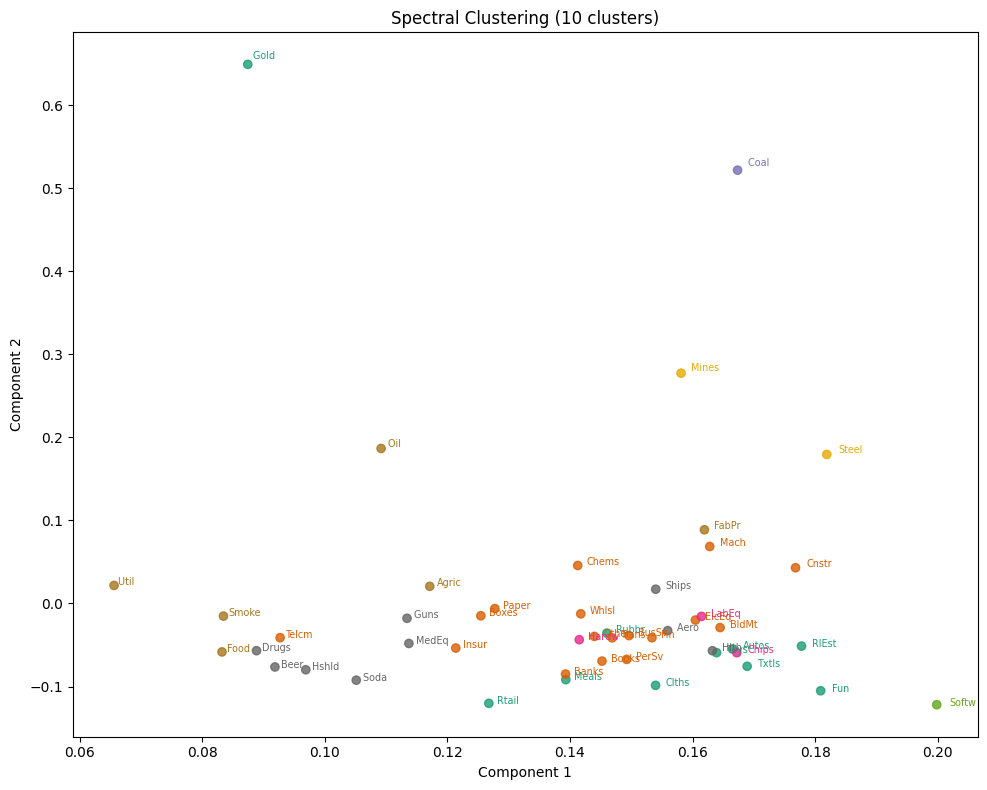

In [26]:
# Spectral clustering
spectral = cluster.SpectralClustering(
    n_clusters=10,
    eigen_solver="arpack",
    #affinity="nearest_neighbors",
    random_state=42,
)
spectral.fit(X.T)   # number of features equals the number observations dates
cmap = ColorMap(spectral.n_clusters, colormap='Dark2')
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(components.iloc[:, 0], components.iloc[:, 1],
           c=cmap[spectral.labels_], alpha=.8)
for t, c, xy in zip(components.index, spectral.labels_,
                    components.iloc[:, :2].values):
    ax.annotate(text=t, xy=xy, xytext=xy * 1.01, color=cmap[c], fontsize='x-small')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title(f"Spectral Clustering ({spectral.n_clusters} clusters)")
plt.tight_layout()
plt.show()

In [27]:
DataFrame({'cluster': spectral.labels_}, index=components.index).sort_values('cluster')

,cluster
Fun,0
Toys,0
Txtls,0
Clths,0
Rubbr,0
Autos,0
RlEst,0
Rtail,0
Meals,0
Gold,1


### EWMA

The **Exponentially-Weighted Moving Average (EWMA) method** assigns greater importance to recent data when estimating the covariance matrix, which is particularly useful for tracking market risk changes.  JP Morgan RiskMetrics (1996) proposed a decay parameter $ \lambda = 0.97 $, implying a monthly decay rate of 0.03.  The **half-life** of the weighting function represents the time required for a weight to decrease by 50%.  


In [15]:
# Compute half-life of risk metrics' lambda for monthly data
def halflife(decay, half=0.5):
    """Returns halflife (t) from its definition: 0.5 = (1-decay)^t"""
    return -np.log(1/half)/np.log(1 - decay)

In [16]:
risk_metrics_lambda = 0.97   # for monthly data
print('Half-life: ', halflife(decay=1-risk_metrics_lambda).round(1), 'months')

Half-life:  22.8 months


In [17]:
def ewma(X, decay):
    """Helper to compute EWMA covariance matrix estimate"""
    weights = (1 - decay)**np.arange(len(X))[::-1]
    return (weights.reshape((1, -1)) * X.T) @ X / weights.sum()

### Shrinkage methods

Covariance matrix estimates can be regularized using shrinkage.
Ledoit and Wolf (1993) proposed shrinking the sample covariance matrix towards an identity matrix,
and derived a closed-form formula to compute the asymptotically
optimal shrinkage parameter $\beta$ by minimizing a MSE criterion:

$$ (1 - \beta) \Sigma + \beta \dfrac{tr(\Sigma)}{N}  I_n $$

Chen et al. (2010) proposed the **Oracle Approximating Shrinkage (OAS) Estimator**
whose convergence is significantly better under the assumption that
the data are Gaussian.


### Volatility of the GMV portfolio

The out-of-sample (OOS) realized volatility of the **Global Minimum Variance Portfolio (GMV)** serves as a benchmark for evaluating covariance estimation accuracy.  The GMV portfolio is designed to minimize total portfolio volatility.  Since it relies on accurate covariance estimates, errors can lead to suboptimal diversification and higher realized volatility.  


Beginning in January 2000, we update the covariance matrix estimate monthly using a rolling 30-year data window, and track the month-ahead return of the GMV portfolio. By the end of the test period, we expect the most accurate covariance matrix estimator to achieve the lowest return volatility.


In [45]:
# Helper method to compute Minimum Variance Portfolio and realized volatility
def gmv(cov, ret):
    """Compute minimum variance portfolio and return"""
    w = np.linalg.inv(cov) @ np.ones((cov.shape[1], 1))
    return float((np.array(ret) @ w/sum(w)).flatten()[0])

In [46]:
# Rolling monthly evaluation
decay = 0.03      # risk metrics monthly decay rate for EWMA
n_components = 10  # for PCA
split = '2000-01' # start rolling OOS prediction tests from this date

In [47]:
r = {}     # collect realized returns
for date in tqdm(rets.index[rets.index >= split]):
    X_train = rets.iloc[rets.index < date, :][-30*12:]   # 30 years of training data 
    X_test = rets.iloc[rets.index == date, :]      # predict one month ahead returns
    r[date] = {}

    # Empirical covariance
    cov = EmpiricalCovariance().fit(X_train).covariance_
    r[date]['Covariance'] = gmv(cov, X_test)
    r[date]['Diagonal'] = gmv(np.diag(np.diag(cov)), X_test)
    r[date]['EWMA'] = gmv(ewma(X_train, decay=decay), X_test)
    r[date][f"PCA-{n_components}"] = gmv(PCA(n_components).fit(X_train).get_covariance(), X_test)
    r[date]['Identity'] = gmv(np.identity(len(cov)), X_test)    
    r[date]['LW'] = gmv(LedoitWolf().fit(X_train).covariance_, X_test)
    r[date]['OAS'] = gmv(OAS().fit(X_train).covariance_, X_test)

100%|██████████| 300/300 [01:01<00:00,  4.86it/s]


In [48]:
ts = DataFrame.from_dict(r, orient='index')
vol = ts.std().rename('realized volatility').to_frame()
print('Realized volatility of minimum variance portfolio')
vol.T

Realized volatility of minimum variance portfolio


,Covariance,Diagonal,EWMA,PCA-10,Identity,LW,OAS
realized volatility,0.035531,0.045541,0.040645,0.036339,0.048569,0.034681,0.035041


Plot evaluation period realized volatility of minimum variance portfolios

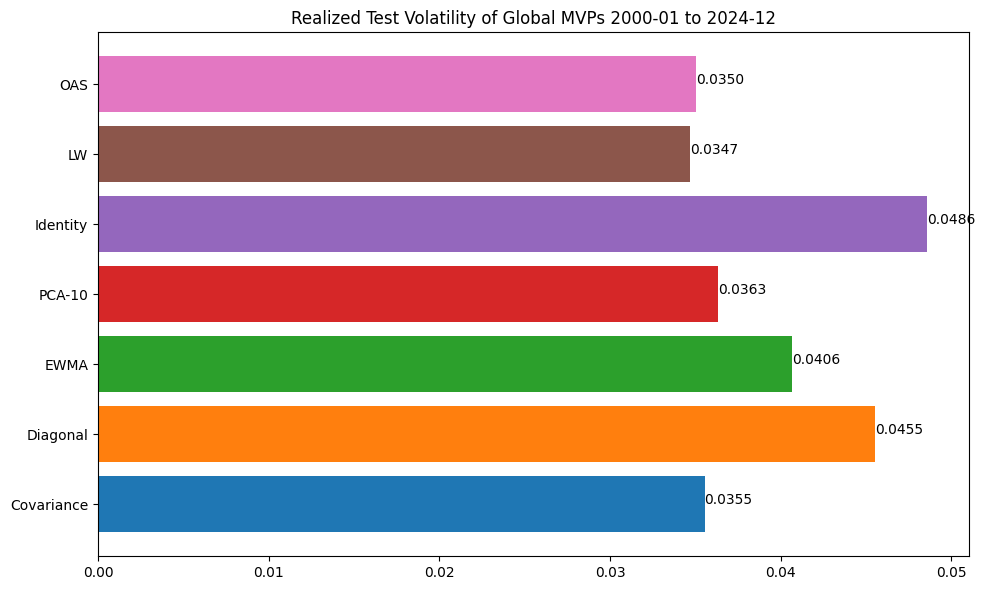

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
values = vol.values.flatten()
ax.barh(vol.index, width=values, color=list(mcolors.TABLEAU_COLORS.values()))
for row, val in enumerate(values):
    ax.annotate(f"{val:.4f}", xy=(val, row))
ax.set_title(f"Realized Test Volatility of Global MVPs {split} to {rets.index[-1]}")
plt.tight_layout()